### Principal Component Analysis for Subsurface Data Analytics in Python 

Here's a simple workflow, demonstration of principal component analysis for subsurface modeling workflows. This should help you get started with building subsurface models that integrate uncertainty in the sample statistics. 

#### Princiapl Component Analysis

Principal Component Analysis one of a variety of methods for dimensional reduction:

Dimensional reduction transforms the data to a lower dimension

* Given features, $𝑋_1,\dots,𝑋_𝑚$  we would require ${m \choose 2}=\frac{𝑚 \cdot (𝑚−1)}{2}$ scatter plots to visualize just the two-dimensional scatter plots.

* Once we have 4 or more variables understanding our data gets very hard.

* Recall the curse of dimensionality, impact inference, modeling and visualization. 

One solution, is to find a good lower dimensional, $𝑝$,  representation of the original dimensions $𝑚$

Benefits of Working in a Reduced Dimensional Representation:

1. Data storage / Computational Time

2. Easier visualization

3. Also takes care of multicollinearity 

#### Orthogonal Transformation 

Convert a set of observations into a set of linearly uncorrelated variables known as principal components

* The number of principal components ($k$) available are min⁡($𝑛−1,𝑚$) 

* Limited by the variables/features, $𝑚$, and the number of data

Components are ordered

* First component describes the larges possible variance / accounts for as much variability as possible
* Next component describes the largest possible remaining variance 
* Up to the maximum number of principal components

Eigen Values / Eigen Vectors

* The Eigen values are the variance explained for each component. 
* The Eigen vectors of the data covariance matrix are the principal components and the Eigen  
* Out of scope – just making the linkage

In [1]:
import os                                                 # to set current working directory 
from sklearn.decomposition import PCA                     # PCA program from scikit learn (package for machine learning)
from sklearn.preprocessing import StandardScaler          # standardize variables to mean of 0.0 and variance of 1.0
import pandas as pd                                       # DataFrames and plotting
import pandas.plotting as pd_plot                         # matrix scatter plots
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
import matplotlib.ticker as mtick
cmap = plt.cm.inferno
import seaborn as sns                                     # advanced plotting

#### Declare functions

Let's define a single function to streamline plotting correlation matrices. 

In [2]:
def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    from matplotlib.colors import ListedColormap          # make a custom colormap
    my_colormap = plt.cm.get_cmap('RdBu_r', 256)          
    newcolors = my_colormap(np.linspace(0, 1, 256))
    white = np.array([256/256, 256/256, 256/256, 1])
    newcolors[65:191, :] = white                          # mask all correlations less than abs(0.8)
    newcmp = ListedColormap(newcolors)
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0,cmap = newcmp)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

#### Read the data table

In [3]:
my_data = pd.read_csv('https://raw.githubusercontent.com/daytum/intake-data/refs/heads/master/daytum_cat/data/unconv_MV.csv')                 # load the comma delimited data file

Let's visualize the first several rows of our data stored in a DataFrame so we can make sure we successfully loaded the data file.

In [4]:
my_data[:7]                                               # preview the first 7 rows of the dataframe

,WellIndex,Por,LogPerm,AI,Brittle,TOC,VR,Production
0,1,15.91,1.67,3.06,14.05,1.36,1.85,177.381958
1,2,15.34,1.65,2.60,31.88,1.37,1.79,1479.767778
2,3,20.45,2.02,3.13,63.67,1.79,2.53,4421.221583
3,4,11.95,1.14,3.90,58.81,0.40,2.03,1488.317629
4,5,19.53,1.83,2.57,43.75,1.40,2.11,5261.094919
5,6,19.47,2.04,2.73,54.37,1.42,2.12,5497.005506
6,7,12.70,1.30,3.70,43.03,0.45,1.95,1784.266285


Let's remove the well index and check the summary summary statistics.

In [5]:
my_data = my_data.iloc[:,1:8]                             # copy all rows and columns 1 through 8, note 0 column is removed
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.719480,15.077006,-10.500000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.003810,0.504978,-0.260000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


Good that we checked the summary statistics, we have some negative values for brittleness and total organic carbon. The is physically imposible.  

* The values must be in error. We know the lowest possible values are 0.0, so we will truncate on 0.0.  

We use the:

```python
df.get_numerical_data()
```

DataFrame member function to get a shallow copy of the data from the DataFrame.  

Since it is a shallow copy, any changes we make to the copy are made to the data in the original DataFrame.  

* This allows us to apply this simple conditional statement to all the data values in the DataFrame all at once.

In [6]:
num = my_data._get_numeric_data()                         # get the numerical values
num[num < 0] = 0                                          # truncate negative values to 0.0
my_data.describe().transpose()                            # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,1000.0,14.950460,3.029634,5.400000,12.85750,14.98500,17.080000,24.65000
LogPerm,1000.0,1.398880,0.405966,0.120000,1.13000,1.39000,1.680000,2.58000
AI,1000.0,2.982610,0.577629,0.960000,2.57750,3.01000,3.360000,4.70000
Brittle,1000.0,49.731480,15.033593,0.000000,39.72250,49.68000,59.170000,93.47000
TOC,1000.0,1.006170,0.499838,0.000000,0.64000,0.99500,1.360000,2.71000
VR,1000.0,1.991170,0.308194,0.900000,1.81000,2.00000,2.172500,2.90000
Production,1000.0,2247.295809,1464.256312,2.713535,1191.36956,1976.48782,3023.594214,12568.64413


This dataset has variables from 1,000 unconventional wells including:

* well average porosity
* log transform of permeability (to linearize the relationships with other variables)
* accoustic impedance (kg/m^3 x m/s x 10^6)
* brittness ratio (%)
* total organic carbon (%)
* vitrinite reflectance (%)
* initial production 90 day average (MCFPD).  

Note, the dataset is synthetic.

#### Calculate the correlation matrix 

For dimensional reduction, a good first step is data visualization.  

Let's start with the correlation matrix.  

We can calculate it and view it in the console with these commands.

```python
corr_matrix = np.corrcoef(my_data, rowvar = False)
```

the input data is a 2D ndarray and $rowvar$ specifies if the variables are in the rows isntead of columns. 

In [7]:
corr_matrix = np.corrcoef(my_data, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.81 -0.51 -0.25  0.71  0.08  0.69]
 [ 0.81  1.   -0.32 -0.15  0.51  0.05  0.57]
 [-0.51 -0.32  1.    0.17 -0.55  0.49 -0.33]
 [-0.25 -0.15  0.17  1.   -0.24  0.3  -0.07]
 [ 0.71  0.51 -0.55 -0.24  1.    0.31  0.5 ]
 [ 0.08  0.05  0.49  0.3   0.31  1.    0.14]
 [ 0.69  0.57 -0.33 -0.07  0.5   0.14  1.  ]]


Note the 1.0 diagonal resulting from the correlation of each variable with themselves.  

Let's use our function declared above to make a graphical correlation matrix visualization.  

* This may inprove our ability to spot features. It relies on the built in correlation matrix method with Numpy DataFrames and MatPlotLib for plotting.

/tmp/ipykernel_259565/1011958880.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  my_colormap = plt.cm.get_cmap('RdBu_r', 256)


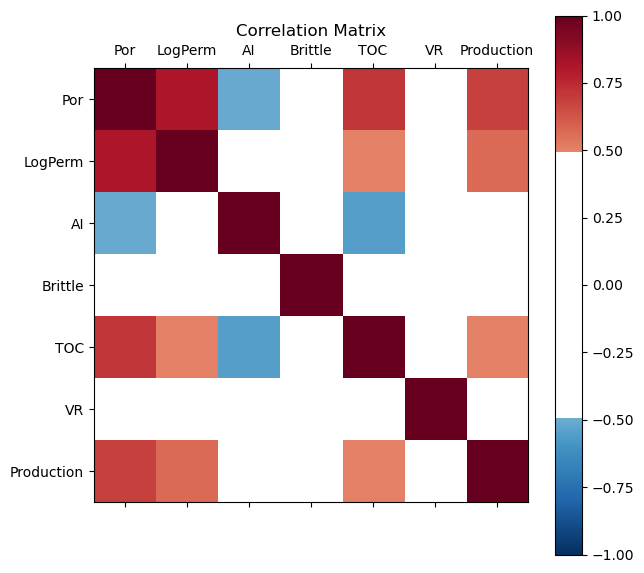

In [8]:
plot_corr(my_data,7)                                      # using our correlation matrix visualization function
plt.show()

This looks good.  There is a mix of bivariate, linear correlation magnitudes. Of course, correlation coeffficients are limited to degree of linear correlations.  

#### Check Matrix Scatter Plots

For more complete information, let's look at the matrix scatter plot from the Pandas package. 

* covariance and correlation are sensitive to outliers and nonlinearity

```python
pd_plot.scatter_matrix(my_data)
```

the $alpha$ alows us to use semitransprent points for easier visualization with dense scatter plots.

the $hist_kwds$ is a set of parameters for the histograms on the diagonal elements.


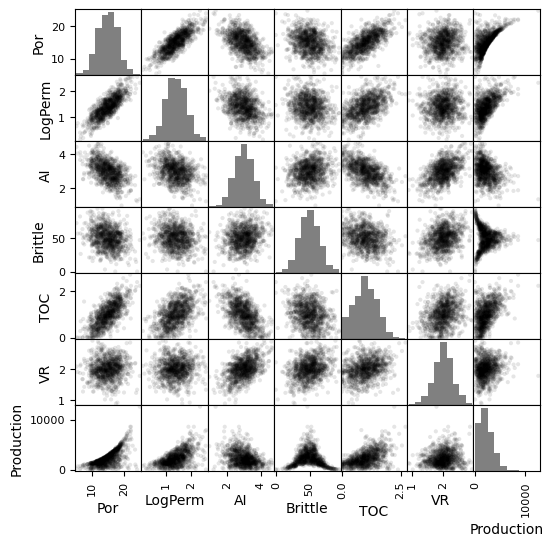

In [9]:
pd_plot.scatter_matrix(my_data, alpha = 0.1,              # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.show()

#### Simple Bivariate Example

Let's simplify the problem to bivariate (2 features), porosity and the log transform of permeability and reduce the number of wells from 1,000 to 100.

In [10]:
my_data_por_perm = my_data.iloc[0:100,0:2]                # extract just por and logperm, 100 samples
my_data_por_perm.describe().transpose()                   # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,100.0,14.9856,2.823016,9.23,12.9275,14.720,16.705,21.00
LogPerm,100.0,1.3947,0.390947,0.36,1.1475,1.365,1.650,2.48


Let's first check the univariate statistics of Por and LogPerm.

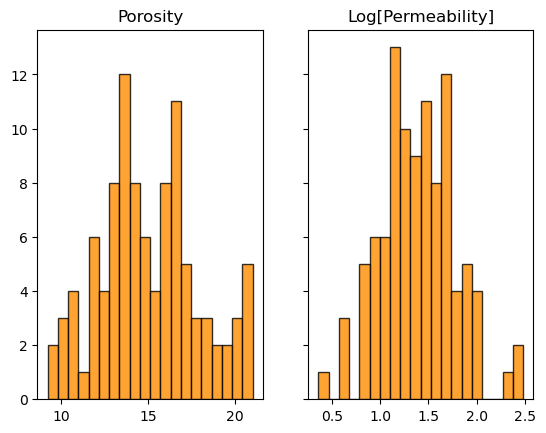

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(my_data_por_perm["Por"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
ax1.set_title('Porosity')
ax2.hist(my_data_por_perm["LogPerm"], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20)
ax2.set_title('Log[Permeability]')
plt.show()

The distributions may actually be Gaussian distributed, regardless they are well behaved, we cannot observe obvious gaps nor truncations.  

Let's look at a scatter plot of porosity vs. log permeability.

This would be the basic command from *matplotlib* to make a scatter plot. 

```python
plt.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"]
```
* the additional parameters are for formatting and labels


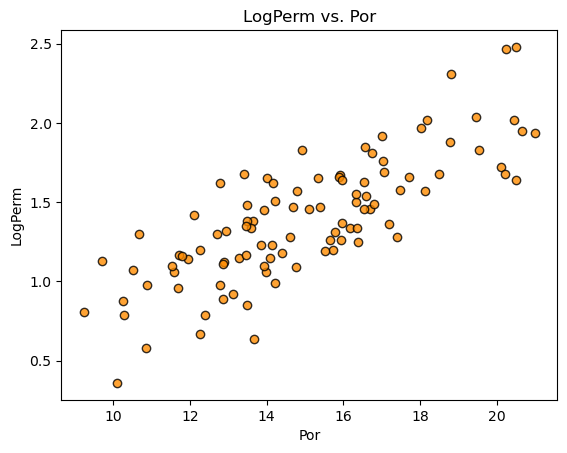

In [12]:
plt.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
plt.title('LogPerm vs. Por'); plt.xlabel('Por'); plt.ylabel('LogPerm')
plt.show()

#### Calculation of Principal Components

With the log of permeability we have a very nice linear relationship with porosity, PCA should work well on this data.  

* We are ready to perform PCA with porosity and log of permeability. 

#### Standardize the Features

We must standardize our variables to have a mean equal to zero, $\bar{x} = 0.0$, and the variance equal to one, $\sigma^{2}_{x} = 1.0$.  

* Otherwise the difference between the scale of porosity and permeability would have a significant impact. This is quite arbitrary!  

* What if we convert the logperm feature from log of milliDacry to log of Darcy? or change the porosity to a fraction instead of a percentage?  

To remove this effect, we should always standardize unless the two variables have the same units and then the range, variance between them is meaningful.

In [13]:
from sklearn.preprocessing import StandardScaler

features = ['Por','LogPerm']
x = my_data_por_perm.loc[:,features].values
mu = np.mean(x, axis=0)
sd = np.std(x, axis=0)
x = StandardScaler().fit_transform(x)                     # standardize the data features to mean = 0, var = 1.0

print("Original Mean Por", np.round(mu[0],2), ', Original Mean LogPerm = ', np.round(mu[1],2)) 
print("Original StDev Por", np.round(sd[0],2), ', Original StDev LogPerm = ', np.round(sd[1],2)) 
print('Mean Transformed Por =',np.round(np.mean(x[:,0]),2),', Mean Transformed LogPerm =',np.round(np.mean(x[:,1]),2))
print('Variance Transformed Por =',np.var(x[:,0]),', Variance Transformed LogPerm =',np.var(x[:,1]))

Original Mean Por 14.99 , Original Mean LogPerm =  1.39
Original StDev Por 2.81 , Original StDev LogPerm =  0.39
Mean Transformed Por = 0.0 , Mean Transformed LogPerm = -0.0
Variance Transformed Por = 1.0000000000000002 , Variance Transformed LogPerm = 1.0


In [14]:
cov = np.cov(x,rowvar = False)
cov

array([[1.01010101, 0.80087707],
       [0.80087707, 1.01010101]])

"x" is a 2D ndarray from Numpy package with the features in columns and the samples in rows.  

* Above we comfirmed that the features in the "x" 2D array are infact standardized. 

It is not a bad idea to check the univariate and bivariate distributions of our standardized variables.

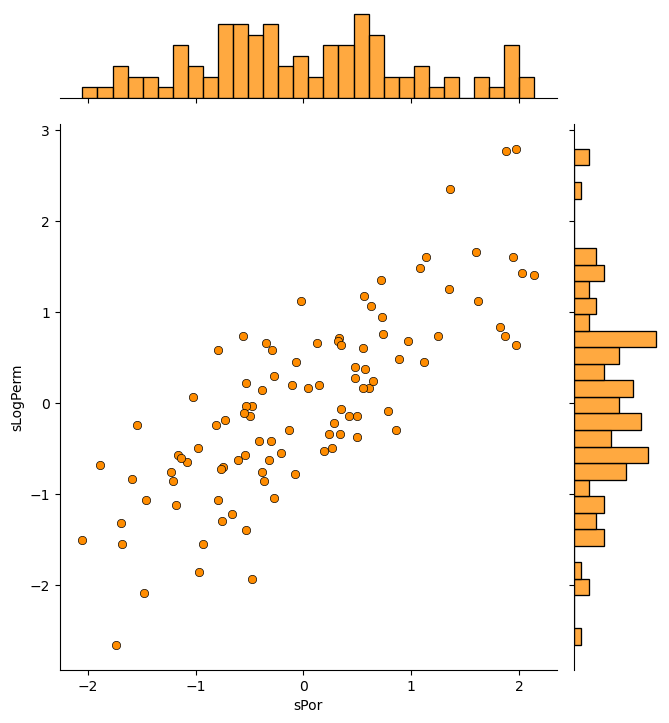

In [15]:
dfS = pd.DataFrame({'sPor': x[:,0], 'sLogPerm': x[:,1]})
sns.jointplot(data=dfS,x='sPor',y='sLogPerm',marginal_kws=dict(bins=30),color='darkorange',edgecolor='black')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.3); plt.show()

Everything looks fine and we are ready to apply principal components analysis.

#### Principal Component Analysis (PCA)

To run PCA with the SciKitLearn machine learning package in Python, we first make a PCA model with a specified number of components and then we 'fit' it to our data. 

```python
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(x)
```
As you will see later with dimensional reduction, we can use matrix math with this model and reduce our data to any dimensionality from 1 to the number of features, m. Let's run the model with number of components equal to number of features, m.

In [16]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(x)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",2
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD 

#### Component Loadings

The first thing we sould do is look at the component loadings.  Let's view them and interpret our result.

In [17]:
print(np.round(pca.components_,3))
print('First Principal Component = ' + str(np.round(pca.components_[0,:],3)))
print('Second Principal Component = ' + str(np.round(pca.components_[1,:],3)))

[[ 0.707  0.707]
 [ 0.707 -0.707]]
First Principal Component = [0.707 0.707]
Second Principal Component = [ 0.707 -0.707]


The components are listed as a 2D array (ndarray) with:

* principal components on the rows
* features on the columns
* the rows are sorted so that the first principal component is the top row and the last principal component is the last row.

#### Proportion of Variance Explained with Principal Components 

It is also important to look at the proportion of the variance described by each principal component.

In [18]:
print('Variance explained by PC1 and PC2 =', np.round(pca.explained_variance_ratio_,3))
print('First Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[0],3)) + ' of the total variance.')
print('Second Principal Component explains ' + str(np.round(pca.explained_variance_ratio_[1],3)) + ' of the total variance.')

Variance explained by PC1 and PC2 = [0.896 0.104]
First Principal Component explains 0.896 of the total variance.
Second Principal Component explains 0.104 of the total variance.


#### Principal Component Scores, Forward and Reverse Projections

We can calculate the principle component scores of the original data. 

* This is effectly a rotation of the data,  aligned with PC1 for the direction of greatest variance.  

* We will calculate the principal component scores with the "transform" function built into PCA and then visualize as a scatter plot. 

* Then to "close the loop" and check what we have done (and our knowledge) we will reverse the PCA, go from the principal component scores back to the standardized features.

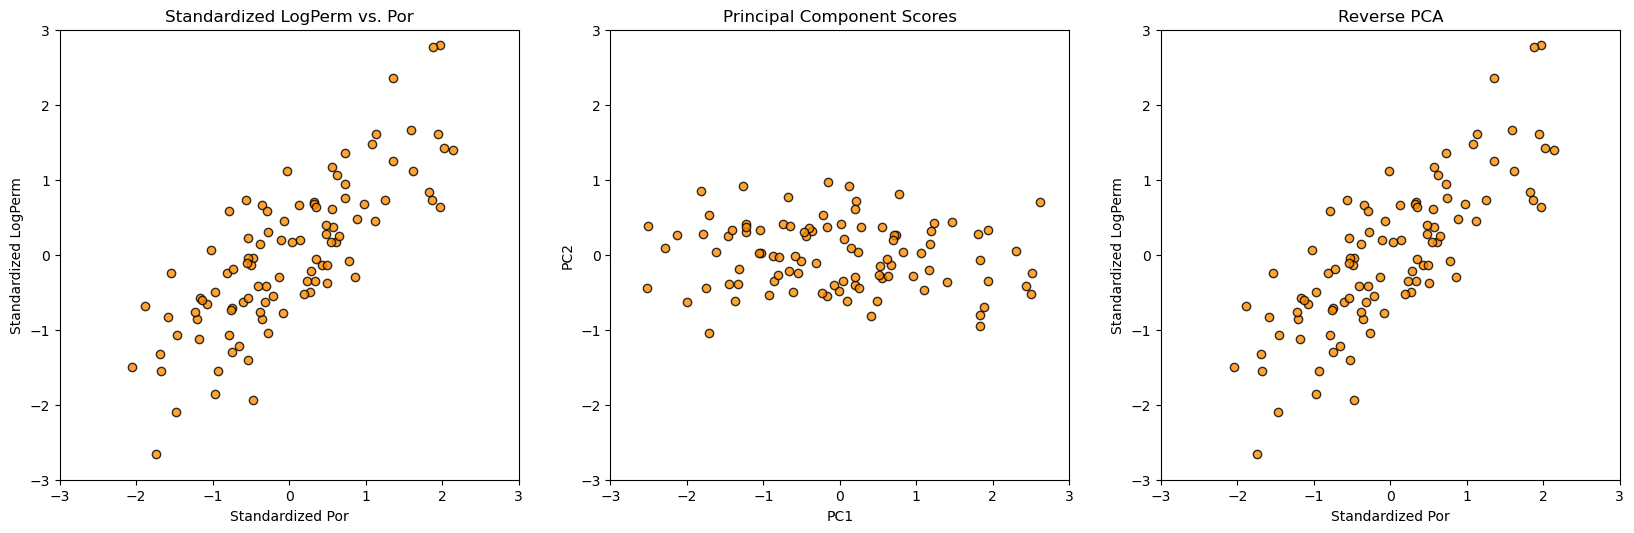

In [19]:
f, (ax101, ax102, ax103) = plt.subplots(1, 3,figsize=(12,3))
f.subplots_adjust(wspace=0.7)

ax101.scatter(x[:,0],x[:,1], s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax101.set_title('Standardized LogPerm vs. Por'); ax101.set_xlabel('Standardized Por'); ax101.set_ylabel('Standardized LogPerm')
ax101.set_xlim([-3,3]); ax101.set_ylim([-3,3]);

x_trans = pca.transform(x)                                # calculate the principal component scores
ax102.scatter(x_trans[:,0],-1*x_trans[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax102.set_title('Principal Component Scores'); ax102.set_xlabel('PC1'); ax102.set_ylabel('PC2')
ax102.set_xlim([-3,3]); ax102.set_ylim([-3,3]);

x_reverse = pca.inverse_transform(x_trans)                        # reverse the principal component scores to standardized values
ax103.scatter(x_reverse[:,0],x_reverse[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax103.set_title('Reverse PCA'); ax103.set_xlabel('Standardized Por'); ax103.set_ylabel('Standardized LogPerm')
ax103.set_xlim([-3,3]); ax103.set_ylim([-3,3]);

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.3, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

The standardized original and reverse PCA cross plots should look exactly the same. If so, the method is working.

#### Conservation of Variance

Let's check the variances of the principle component scores, since we have calculated them now.

* we calculate the variance for each of the original features

* then sum to get the original total variance

* we calculate the variance for each of the transformed, principal component scores

* then we sum to get the transformed total variance

We note the:

* the first principal component score has larger variance than the second component scores

* total variance is preserved over the transformation, the sum of variance is the same for original features and m principal compenent scores

In [20]:
print('Variance of the 2 features:')
print(np.var(x, axis = 0))

print('\nTotal Variance from Original Features:')
print(np.sum(np.var(x, axis = 0)))

print('\nVariance of the 2 principle components:')
print(np.round(np.var(x_trans, axis = 0),2))

print('\nTotal Variance from Original Features:')
print(round(np.sum(np.var(x_trans, axis = 0)),2))

Variance of the 2 features:
[1. 1.]

Total Variance from Original Features:
2.0

Variance of the 2 principle components:
[1.79 0.21]

Total Variance from Original Features:
2.0


#### Independence of Principal Component Scores

Let's check the correlations for the original features vs. our projected features.

In [21]:
print('\nCorrelation Matrix of the 2 original features components:')
print(np.round(np.corrcoef(x, rowvar = False),2))

print('\nCorrelation Matrix of the 2 principle components\' scores:')
print(np.round(np.corrcoef(x_trans, rowvar = False),2))


Correlation Matrix of the 2 original features components:
[[1.   0.79]
 [0.79 1.  ]]

Correlation Matrix of the 2 principle components' scores:
[[1. 0.]
 [0. 1.]]


We have projected our original features with high correlation to 2 new features with no correlation!

#### Principal Component Analysis By-hand with Eigenvalue and Eigen Vector Calculator

Let's show PCA by-hand with the standardized features and the Eigen calculation.

Eigen Vectors:
[[ 0.71 -0.71]
 [ 0.71  0.71]]
First Eigen Vector: [0.70710678 0.70710678]
Second Eigen Vector: [-0.70710678  0.70710678]
Eigen Values:
[1.81 0.21]


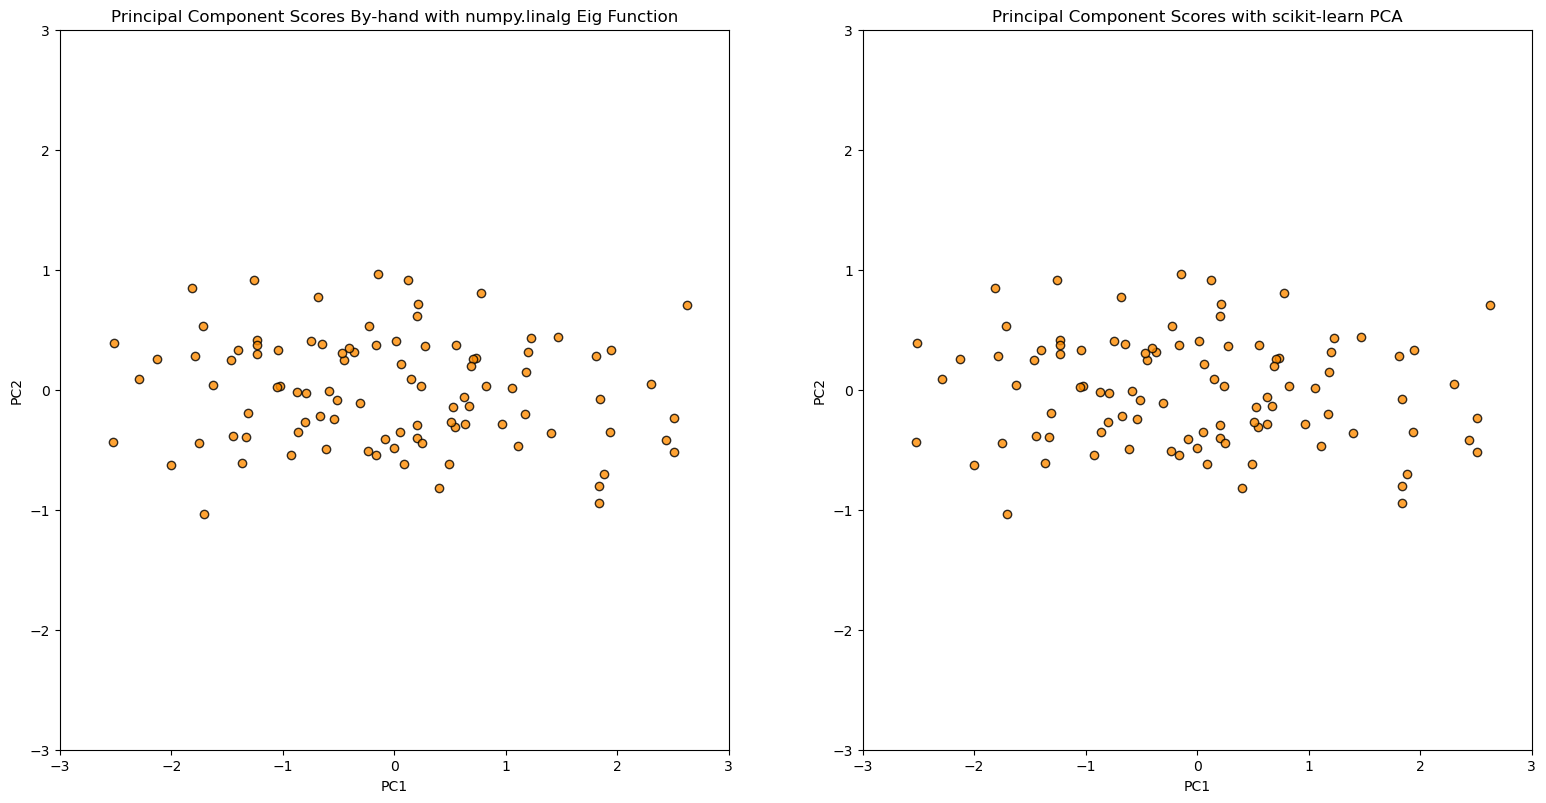

In [22]:
from numpy.linalg import eig
eigen_values,eigen_vectors = eig(cov)
print('Eigen Vectors:\n' +  str(np.round(eigen_vectors,2)))
print('First Eigen Vector: ' + str(eigen_vectors[:,0]))
print('Second Eigen Vector: ' + str(eigen_vectors[:,1]))
print('Eigen Values:\n' +  str(np.round(eigen_values,2)))
PC = eigen_vectors.T.dot(x.T)
plt.subplot(121)
plt.scatter(PC[0,:],PC[1,:],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
plt.title('Principal Component Scores By-hand with numpy.linalg Eig Function'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim([-3,3]); plt.ylim([-3,3]);

plt.subplot(122)
plt.scatter(x_trans[:,0],-1*x_trans[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
plt.title('Principal Component Scores with scikit-learn PCA'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.xlim([-3,3]); plt.ylim([-3,3]);

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.3, top=1.5, wspace=0.2, hspace=0.3)
plt.show()

#### Demostration of Dimensional Reduction

Now let's attempt **dimensional reduction** by only retaining the first principle component.  We will go from original values to predictions of original values. Recall we were able to explain about 90% of the variance with the first principal component so the result should look 'pretty good', right?  We will do the whole thing by hand to make it as simple/understandable as possible for this first time through.  Later we will be much more compact.  The steps: 

1. start with the original porosity and permeability data 
2. standardize such that Por and LogPerm have a mean of 0.0 and a variance of 1.0
3. calculate the 2 principal component model, visualize the principal component scores
4. remove the 2nd principal component by setting the associated component scores to 0.0
5. reverse the principal component by matrix multiplication of the scores with the component loadings
6. apply matrix math to restore the original mean and variance

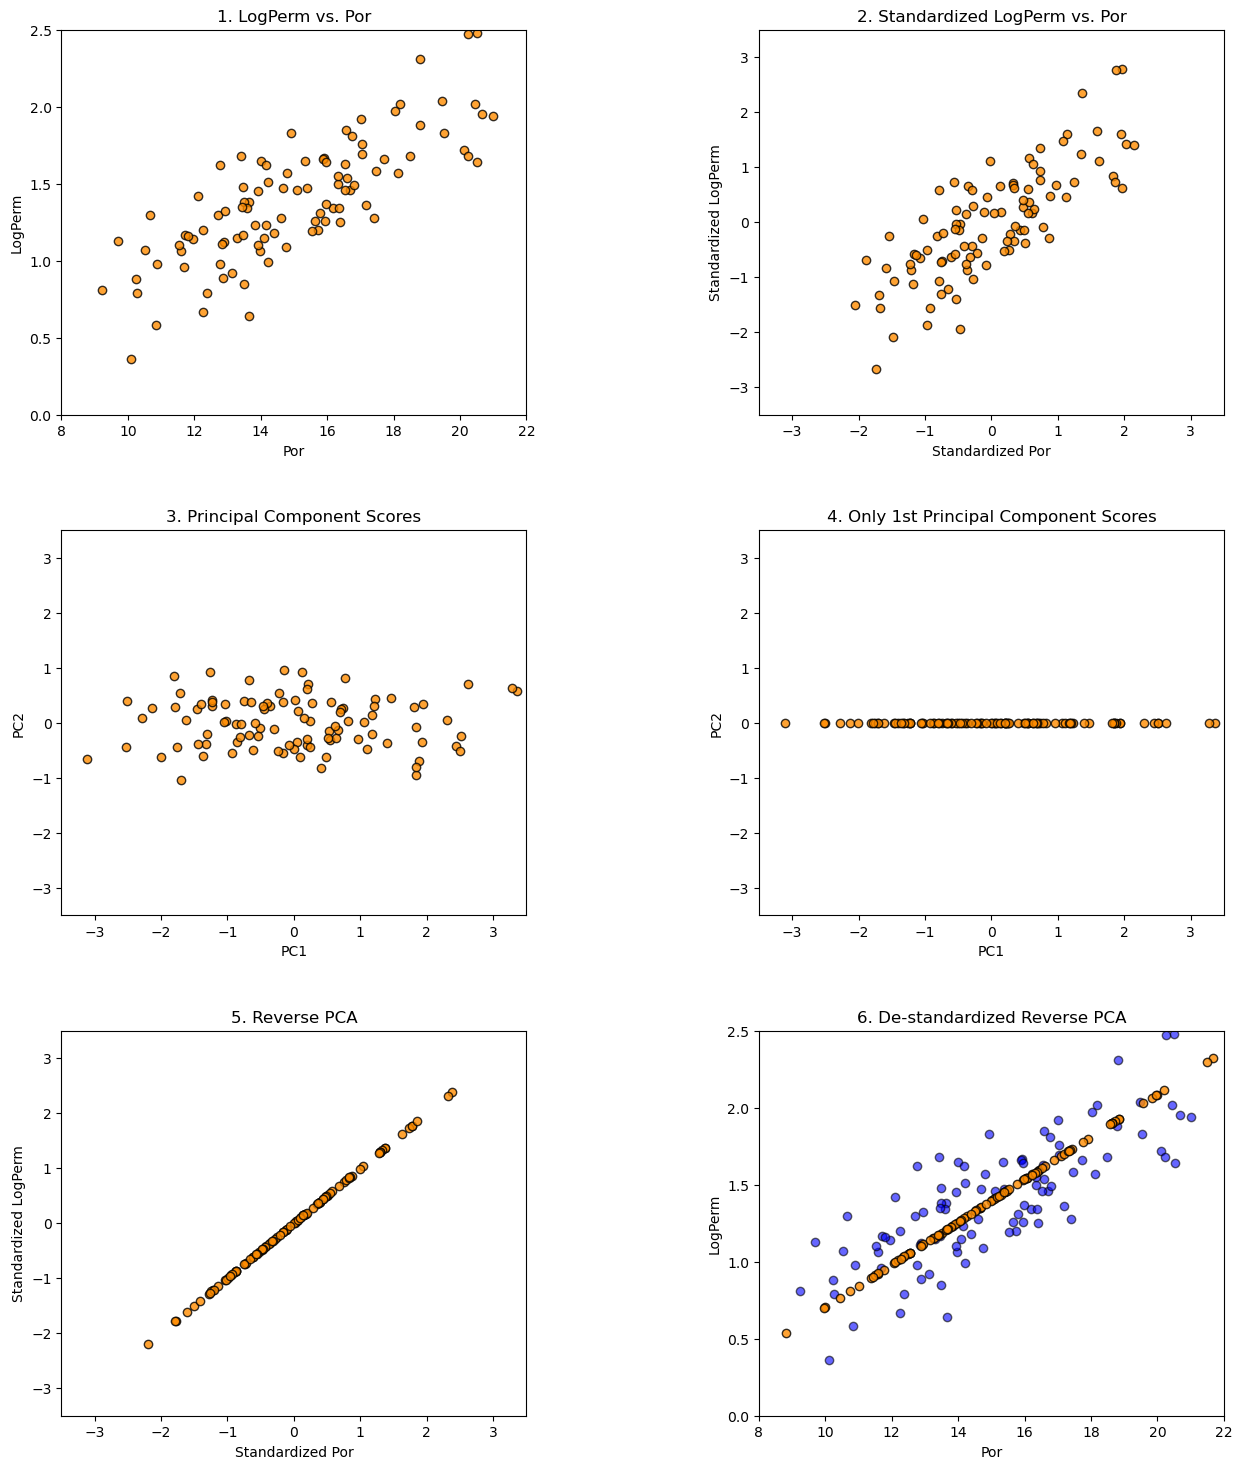

In [23]:
nComp = 1
f, ((ax201, ax202), (ax203, ax204), (ax205, ax206)) = plt.subplots(3, 2,figsize=(15,18))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax201.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax201.set_title('1. LogPerm vs. Por'); ax201.set_xlabel('Por'); ax201.set_ylabel('LogPerm')
ax201.set_xlim([8,22]); ax201.set_ylim([0,2.5])

mu = np.mean(np.vstack((my_data_por_perm["Por"].values,my_data_por_perm["LogPerm"].values)), axis=1)
sd = np.std(np.vstack((my_data_por_perm["Por"].values,my_data_por_perm["LogPerm"].values)), axis=1)
x = StandardScaler().fit_transform(x)                     # standardize the data features to mean = 0, var = 1.0

ax202.scatter(x[:,0],x[:,1], s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax202.set_title('2. Standardized LogPerm vs. Por'); ax202.set_xlabel('Standardized Por'); ax202.set_ylabel('Standardized LogPerm')
ax202.set_xlim([-3.5,3.5]); ax202.set_ylim([-3.5,3.5])

n_components = 2                                          # build principal component model with 2 components
pca = PCA(n_components=n_components)
pca.fit(x)

x_trans = pca.transform(x)                                # calculate principal component scores
ax203.scatter(x_trans[:,0],-1*x_trans[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax203.set_title('3. Principal Component Scores'); ax203.set_xlabel('PC1'); ax203.set_ylabel('PC2')
ax203.set_xlim([-3.5,3.5]); ax203.set_ylim([-3.5,3.5])

x_trans[:,1] = 0.0                                         # zero / remove the 2nd principal component 

ax204.scatter(x_trans[:,0],x_trans[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax204.set_title('4. Only 1st Principal Component Scores'); ax204.set_xlabel('PC1'); ax204.set_ylabel('PC2')
ax204.set_xlim([-3.5,3.5]); ax204.set_ylim([-3.5,3.5])

xhat = pca.inverse_transform(x_trans)                             # reverse the principal component scores to standardized values
ax205.scatter(xhat[:,0],xhat[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax205.set_title('5. Reverse PCA'); ax205.set_xlabel('Standardized Por'); ax205.set_ylabel('Standardized LogPerm')
ax205.set_xlim([-3.5,3.5]); ax205.set_ylim([-3.5,3.5])

xhat = np.dot(pca.inverse_transform(x)[:,:nComp], pca.components_[:nComp,:])
xhat = sd*xhat + mu                                       # remove the standardization

ax206.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="blue", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6, linewidths=1.0, edgecolors="black")
ax206.scatter(xhat[:,0],xhat[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax206.set_title('6. De-standardized Reverse PCA'); ax206.set_xlabel('Por'); ax206.set_ylabel('LogPerm')
ax206.set_xlim([8,22]); ax206.set_ylim([0,2.5])

plt.show()

Let's put the original data and the resulting lower dimensional model side-by-side and check the resulting variances.

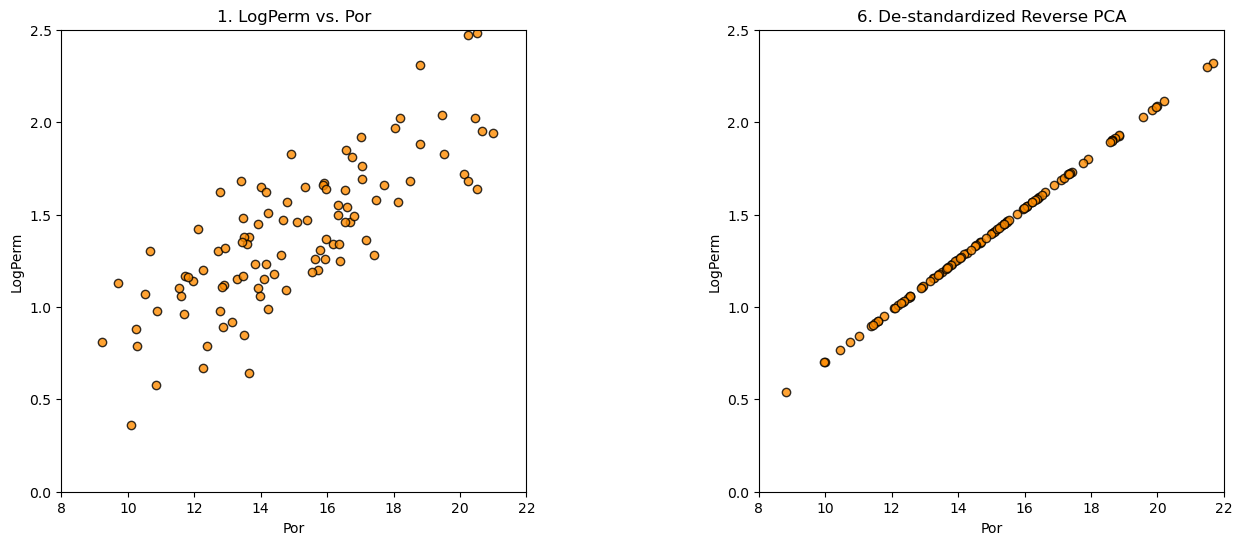

Variance Por = 7.89 , Variance Reduced Dimensional Por = 7.073 Fraction =  0.896
Variance LogPerm = 0.151 , Variance Reduced Dimensional LogPerm = 0.136 Fraction =  0.896
Total Variance = 8.041 , Total Variance Reduced Dimension = 7.208 Fraction =  0.896


In [24]:
f, (ax201, ax206) = plt.subplots(1, 2,figsize=(15,6))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax201.scatter(my_data_por_perm["Por"],my_data_por_perm["LogPerm"],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax201.set_title('1. LogPerm vs. Por'); ax201.set_xlabel('Por'); ax201.set_ylabel('LogPerm')
ax201.set_xlim([8,22]); ax201.set_ylim([0,2.5])

ax206.scatter(xhat[:,0],xhat[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=1.0, edgecolors="black")
ax206.set_title('6. De-standardized Reverse PCA'); ax206.set_xlabel('Por'); ax206.set_ylabel('LogPerm')
ax206.set_xlim([8,22]); ax206.set_ylim([0,2.5])
plt.show()

var_por = np.var(my_data_por_perm["Por"]); var_por_hat = np.var(xhat[:,0]);
var_logperm = np.var(my_data_por_perm["LogPerm"]); var_logperm_hat = np.var(xhat[:,1]);
print('Variance Por =',np.round(var_por,3),', Variance Reduced Dimensional Por =',np.round(var_por_hat,3),'Fraction = ',np.round(var_por_hat/var_por,3))
print('Variance LogPerm =',np.round(var_logperm,3),', Variance Reduced Dimensional LogPerm =',np.round(var_logperm_hat,3),'Fraction = ',np.round(var_logperm_hat/var_logperm,3))
print('Total Variance =',np.round(var_por + var_logperm,3), ', Total Variance Reduced Dimension =',np.round(var_por_hat+var_logperm_hat,3),'Fraction = ',np.round((var_por_hat+var_logperm_hat)/(var_por+var_logperm),3))

We got a model that explains 89.6% of the variance for both porosity and log permeability.

#### Return to the original 6 predictors / features

We will go back to the original data file and this time extract all 6 predictor variables and the first 500 samples.  

In [25]:
my_data_f6 = my_data.iloc[0:500,0:6]                      # extract the 6 predictors, 500 samples

It is a good idea to start with the summary statistics for our data.

In [26]:
my_data_f6.describe().transpose()                         # calculate summary statistics for the data

,count,mean,std,min,25%,50%,75%,max
Por,500.0,14.89936,2.985967,5.40,12.8500,14.900,17.0125,23.85
LogPerm,500.0,1.40010,0.409616,0.18,1.1475,1.380,1.6700,2.58
AI,500.0,2.99244,0.563674,1.21,2.5900,3.035,3.3725,4.70
Brittle,500.0,49.74682,15.212123,0.00,39.3125,49.595,59.2075,93.47
TOC,500.0,0.99800,0.503635,0.00,0.6400,0.960,1.3500,2.71
VR,500.0,1.99260,0.307434,0.90,1.8200,2.010,2.1725,2.84


Let's also calculate a correlation matrix and view it. 

In [27]:
corr_matrix = np.corrcoef(my_data_f6, rowvar = False)
print(np.around(corr_matrix,2))                           # print the correlation matrix to 2 decimals

[[ 1.    0.79 -0.49 -0.25  0.71  0.12]
 [ 0.79  1.   -0.32 -0.13  0.48  0.04]
 [-0.49 -0.32  1.    0.14 -0.53  0.47]
 [-0.25 -0.13  0.14  1.   -0.24  0.24]
 [ 0.71  0.48 -0.53 -0.24  1.    0.35]
 [ 0.12  0.04  0.47  0.24  0.35  1.  ]]


We will need to standardize each variable to have a mean of zero and a variance of one.  Let's do that and check the results. In the console below we print all the initial and standardized means and variances for all 6 predictors. 

In [28]:
from sklearn.preprocessing import StandardScaler

features = ['Por','LogPerm','AI','Brittle','TOC','VR']
x_f6 = my_data_f6.loc[:,features].values
mu_f6 = np.mean(x_f6, axis=0)
sd_f6 = np.std(x_f6, axis=0)
x_f6 = StandardScaler().fit_transform(x_f6)
 
print("Original Means", features[:], np.round(mu_f6[:],2)) 
print("Original StDevs", features[:],np.round(sd_f6[:],2)) 
print('Mean Transformed =',features[:],np.round(x.mean(axis=0),2))
print('Variance Transformed Por =',features[:],np.round(x.var(axis=0),2))

Original Means ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [14.9   1.4   2.99 49.75  1.    1.99]
Original StDevs ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [ 2.98  0.41  0.56 15.2   0.5   0.31]
Mean Transformed = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [0. 0.]
Variance Transformed Por = ['Por', 'LogPerm', 'AI', 'Brittle', 'TOC', 'VR'] [1. 1.]


We whould also check the univariate distributions for each variable.

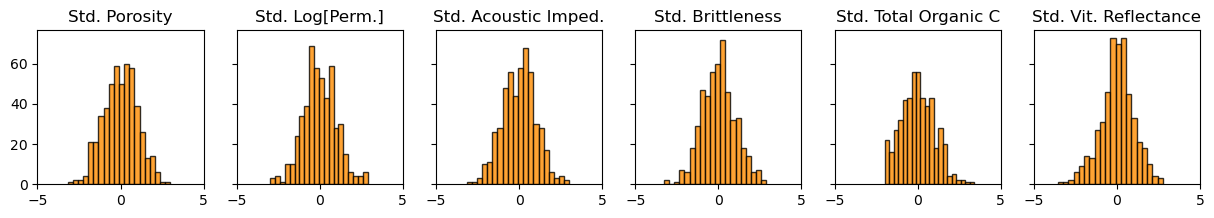

In [29]:
f, (ax6,ax7,ax8,ax9,ax10,ax11) = plt.subplots(1, 6, sharey=True, figsize=(15,2))
ax6.hist(x_f6[:,0], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax6.set_title('Std. Porosity'); ax6.set_xlim(-5,5)
ax7.hist(x_f6[:,1], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax7.set_title('Std. Log[Perm.]'); ax7.set_xlim(-5,5)
ax8.hist(x_f6[:,2], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax8.set_title('Std. Acoustic Imped.'); ax8.set_xlim(-5,5)
ax9.hist(x_f6[:,3], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax9.set_title('Std. Brittleness'); ax9.set_xlim(-5,5)
ax10.hist(x_f6[:,4], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax10.set_title('Std. Total Organic C'); ax10.set_xlim(-5,5)
ax11.hist(x_f6[:,5], alpha = 0.8, color = 'darkorange', edgecolor = 'black', bins=20); ax11.set_title('Std. Vit. Reflectance'); ax11.set_xlim(-5,5)
plt.show()

The summary statistics and distributions look good.  No obvious missing data, gaps, significant truncations, spikes or outliers.  We are ready to peform principal component analysis on our 6 features.

In [30]:
n_components = 6
pca_f6 = PCA(n_components=n_components)
pca_f6.fit(x_f6)

print(np.round(pca_f6.components_,3))                     # visualize the component loadings

[[ 0.558  0.476 -0.405 -0.211  0.504  0.01 ]
 [ 0.117  0.114  0.432  0.323  0.229  0.794]
 [ 0.019  0.124 -0.384  0.898 -0.07  -0.157]
 [ 0.214  0.674  0.424  0.006 -0.526 -0.21 ]
 [ 0.784 -0.522  0.031  0.046 -0.331  0.019]
 [ 0.12  -0.138  0.566  0.206  0.55  -0.549]]


Let's look at the component loadings first.  Each row is a component, top row is the first principal component (PC1), next row is the second principal component (PC2) up to the last row the sixth principal component (PC6).  The columns are the features ordered from 'Por', 'LogPerm', 'AI', 'Brittle', 'TOC', to 'VR'.

First principal component is mainly composed of porosity, log permeability, acoustic impedanced and total organic carbon, suggesting that the way they vary together is responsible for much of the variance.  The next principle component is mainly composed of vitrinite reflectance.  The third principal coordinate is mainly composed of brittleness and so on.

#### Scree Plot to Support Number of Dimensions to Retain

To assist in this interpretation we should consider the variance contributions from each principal component.

Variance explained by PC1 thru PC6 = [0.462 0.246 0.149 0.11  0.024 0.009]


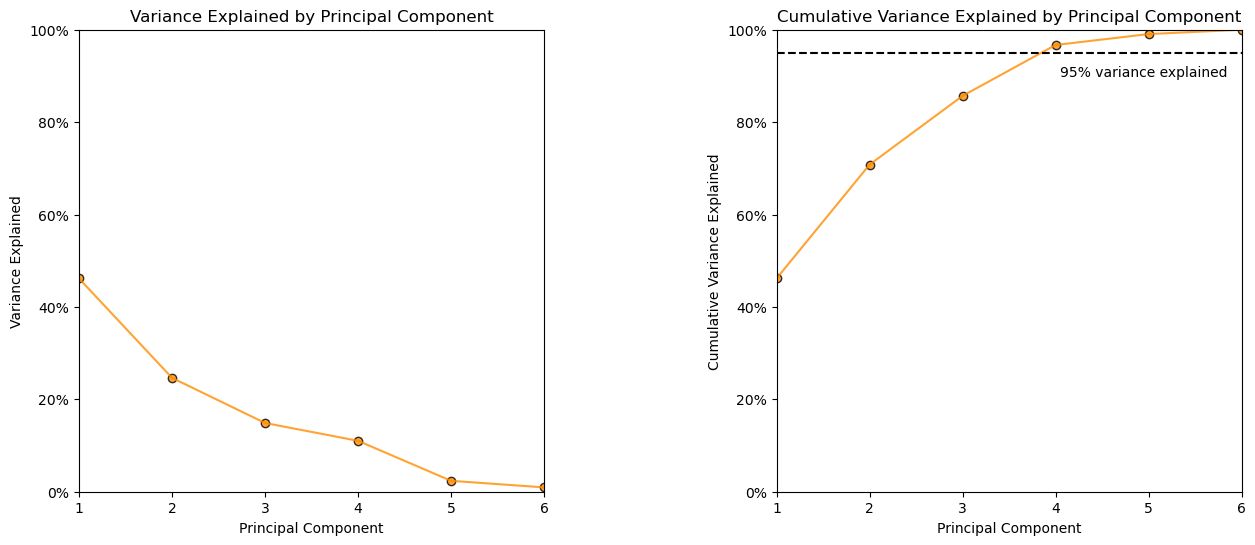

In [31]:
print('Variance explained by PC1 thru PC6 =', np.round(pca_f6.explained_variance_ratio_,3))

f, (ax10, ax11) = plt.subplots(1, 2,figsize=(15,6))
f.subplots_adjust(wspace=0.5,hspace = 0.3)

ax10.plot(np.arange(1,7,1),pca_f6.explained_variance_ratio_*100,color='darkorange',alpha=0.8)
ax10.scatter(np.arange(1,7,1),pca_f6.explained_variance_ratio_*100,color='darkorange',alpha=0.8,edgecolor='black')
ax10.set_xlabel('Principal Component'); ax10.set_ylabel('Variance Explained'); ax10.set_title('Variance Explained by Principal Component')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt); ax10.set_xlim(1,6); ax10.set_ylim(0,100.0)
ax10.yaxis.set_major_formatter(yticks)

ax11.plot(np.arange(1,7,1),np.cumsum(pca_f6.explained_variance_ratio_*100),color='darkorange',alpha=0.8)
ax11.scatter(np.arange(1,7,1),np.cumsum(pca_f6.explained_variance_ratio_*100),color='darkorange',alpha=0.8,edgecolor='black')
ax11.plot([1,6],[95,95], color='black',linestyle='dashed')
ax11.set_xlabel('Principal Component'); ax11.set_ylabel('Cumulative Variance Explained'); ax11.set_title('Cumulative Variance Explained by Principal Component')
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt); ax11.set_xlim(1,6); ax11.set_ylim(0,100.0); ax11.annotate('95% variance explained',[4.05,90])
ax11.yaxis.set_major_formatter(yticks)

# plt.show()

We can see that about 46% of the variance is described by the 1st principal component and then about 25% is described by the 2nd principal component etc.  

#### Independence of Principal Component Scores

Let's check the pairwise feature correlations before and after the projection.

In [32]:
print('\nCorrelation Matrix of the 6 original features components:')
print(np.round(np.corrcoef(x_f6, rowvar = False),2))

print('\nCorrelation Matrix of the 6 principle components\' scores:')
print(np.round(np.corrcoef(pca_f6.transform(x_f6), rowvar = False),2))


Correlation Matrix of the 6 original features components:
[[ 1.    0.79 -0.49 -0.25  0.71  0.12]
 [ 0.79  1.   -0.32 -0.13  0.48  0.04]
 [-0.49 -0.32  1.    0.14 -0.53  0.47]
 [-0.25 -0.13  0.14  1.   -0.24  0.24]
 [ 0.71  0.48 -0.53 -0.24  1.    0.35]
 [ 0.12  0.04  0.47  0.24  0.35  1.  ]]

Correlation Matrix of the 6 principle components' scores:


[[ 1.  0. -0.  0. -0.  0.]
 [ 0.  1.  0.  0. -0. -0.]
 [-0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -0.  0.]
 [-0. -0.  0. -0.  1.  0.]
 [ 0. -0.  0.  0.  0.  1.]]


The new projected features (even without dimensionality reduction, $p=m$) all have pairwise correlations of 0.0! 

* all the projected features are linearly independent of each other

#### Reduced Dimensionality Impact on a 2 Feature Relationship

It would be interesting to look just at the porosity vs. log permeability bivariate relationship when we retain $1,\ldots,6$ principal components.  

* to do this we use matrix math to reverse with PCA and the standardization with various number of principal component and then plot the scattter plots of log permeability vs. porosity.

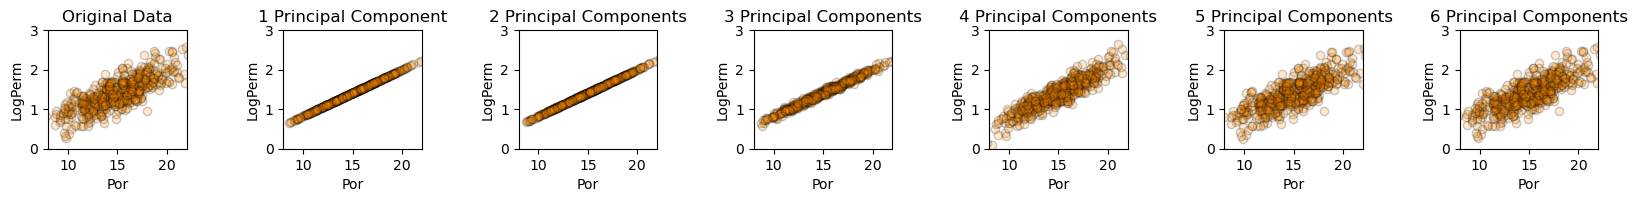

In [33]:
nComp = 6
xhat_6d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_6d = sd_f6*xhat_6d + mu_f6

nComp = 5
xhat_5d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_5d = sd_f6*xhat_5d + mu_f6

nComp = 4
xhat_4d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_4d = sd_f6*xhat_4d + mu_f6

nComp = 3
xhat_3d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_3d = sd_f6*xhat_3d + mu_f6

nComp = 2
xhat_2d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_2d = sd_f6*xhat_2d + mu_f6

nComp = 1
xhat_1d = np.dot(pca_f6.transform(x_f6)[:,:nComp], pca_f6.components_[:nComp,:])
xhat_1d = sd_f6*xhat_1d + mu_f6

f, (ax12, ax13, ax14, ax15, ax16, ax17, ax18) = plt.subplots(1, 7,figsize=(20,20))
f.subplots_adjust(wspace=0.7)

ax12.scatter(my_data_f6["Por"],my_data_f6["LogPerm"],s=None, c="darkorange",marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax12.set_title('Original Data'); ax12.set_xlabel('Por'); ax12.set_ylabel('LogPerm')
ax12.set_ylim(0.0,3.0); ax12.set_xlim(8,22); ax12.set_aspect(4.0); 

ax13.scatter(xhat_1d[:,0],xhat_1d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax13.set_title('1 Principal Component'); ax13.set_xlabel('Por'); ax13.set_ylabel('LogPerm')
ax13.set_ylim(0.0,3.0); ax13.set_xlim(8,22); ax13.set_aspect(4.0)

ax14.scatter(xhat_2d[:,0],xhat_2d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax14.set_title('2 Principal Components'); ax14.set_xlabel('Por'); ax14.set_ylabel('LogPerm')
ax14.set_ylim(0.0,3.0); ax14.set_xlim(8,22); ax14.set_aspect(4.0)

ax15.scatter(xhat_3d[:,0],xhat_3d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax15.set_title('3 Principal Components'); ax15.set_xlabel('Por'); ax15.set_ylabel('LogPerm')
ax15.set_ylim(0.0,3.0); ax15.set_xlim(8,22); ax15.set_aspect(4.0)

ax16.scatter(xhat_4d[:,0],xhat_4d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax16.set_title('4 Principal Components'); ax16.set_xlabel('Por'); ax16.set_ylabel('LogPerm')
ax16.set_ylim(0.0,3.0); ax16.set_xlim(8,22); ax16.set_aspect(4.0)

ax17.scatter(xhat_5d[:,0],xhat_5d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax17.set_title('5 Principal Components'); ax17.set_xlabel('Por'); ax17.set_ylabel('LogPerm')
ax17.set_ylim(0.0,3.0); ax17.set_xlim(8,22); ax17.set_aspect(4.0)

ax18.scatter(xhat_6d[:,0],xhat_6d[:,1],s=None, c="darkorange", marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.2, linewidths=1.0, edgecolors="black")
ax18.set_title('6 Principal Components'); ax18.set_xlabel('Por'); ax18.set_ylabel('LogPerm')
ax18.set_ylim(0.0,3.0); ax18.set_xlim(8,22); ax18.set_aspect(4.0)

plt.show()

Very interesting to watch the accuracy of the bivariate relationship between log permeability and porosity imporve as we include more components.  Let's check the variances.  


In [34]:
print('1 Principal Component : Variance Por =',np.round(np.var(xhat_1d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_1d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('2 Principal Components: Variance Por =',np.round(np.var(xhat_2d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_2d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('3 Principal Components: Variance Por =',np.round(np.var(xhat_3d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_3d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('4 Principal Components: Variance Por =',np.round(np.var(xhat_4d[:,0])/(sd_f6[0]*sd_f6[0]),2),' Variance Log Perm = ',np.round(np.var(xhat_4d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('5 Principal Components: Variance Por =',np.round(np.var(xhat_5d[:,0])/(sd_f6[0]*sd_f6[0]),2),'  Variance Log Perm = ',np.round(np.var(xhat_5d[:,1])/(sd_f6[1]*sd_f6[1]),2))

print('6 Principal Components: Variance Por =',np.round(np.var(xhat_6d[:,0])/(sd_f6[0]*sd_f6[0]),2),'  Variance Log Perm = ',np.round(np.var(xhat_6d[:,1])/(sd_f6[1]*sd_f6[1]),2))


1 Principal Component : Variance Por = 0.86  Variance Log Perm =  0.63
2 Principal Components: Variance Por = 0.88  Variance Log Perm =  0.65
3 Principal Components: Variance Por = 0.88  Variance Log Perm =  0.66
4 Principal Components: Variance Por = 0.91  Variance Log Perm =  0.96
5 Principal Components: Variance Por = 1.0   Variance Log Perm =  1.0
6 Principal Components: Variance Por = 1.0   Variance Log Perm =  1.0


This is interesting.  With the first principal component we decribe 86% of the porosity variance. The next two principal components do not provide much assistance. Then there is a jump with the 4th and 5th principal components.  

* of course, the problem is 6 dimensional, not just porosity vs. log permeability, but is it interesting to see the relationship between number of principal components and variance variance retianed by-feature  

* principal components do not uniformly described each feature

#### Reduced Dimensionality Impact on Matrix Scatter Plots of All Features

Let's look at the matrix scatter plots for see all of the bivariate combinations.

* first some book keeping, we have to put the 6D reduced dimensionality models in DataFrames (there are currently Numpy ndarrays.

In [35]:
df_1d = pd.DataFrame(data=xhat_1d,columns=features)   
df_2d = pd.DataFrame(data=xhat_2d,columns=features)
df_3d = pd.DataFrame(data=xhat_3d,columns=features)
df_4d = pd.DataFrame(data=xhat_4d,columns=features)
df_5d = pd.DataFrame(data=xhat_5d,columns=features)
df_6d = pd.DataFrame(data=xhat_6d,columns=features)

Now we can go ahead and produce the matrix scatter plots with these DataFrames. It is very interesting to see the accuracy of the bivariate plots improve as we add principal components.  Also, with only two principal components we capture some of the bivariate relationships quite well for some of the variable pairs.

<Figure size 640x480 with 0 Axes>

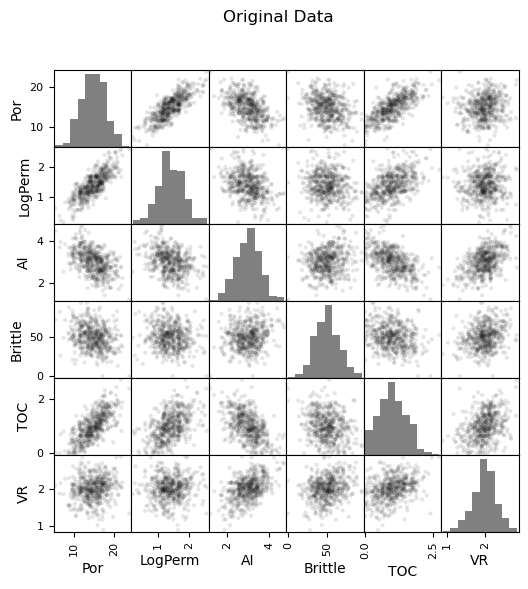

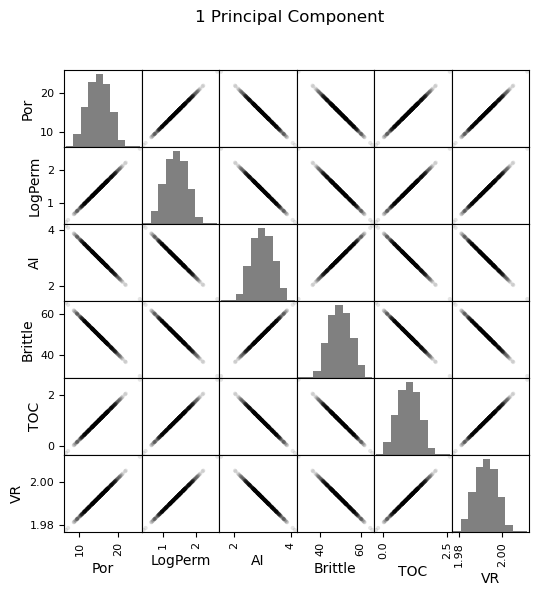

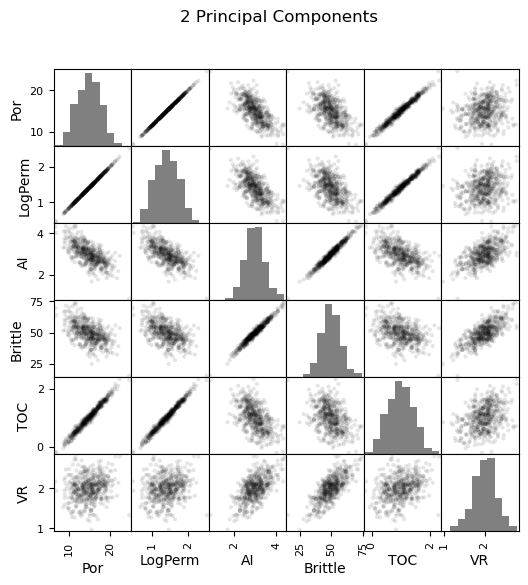

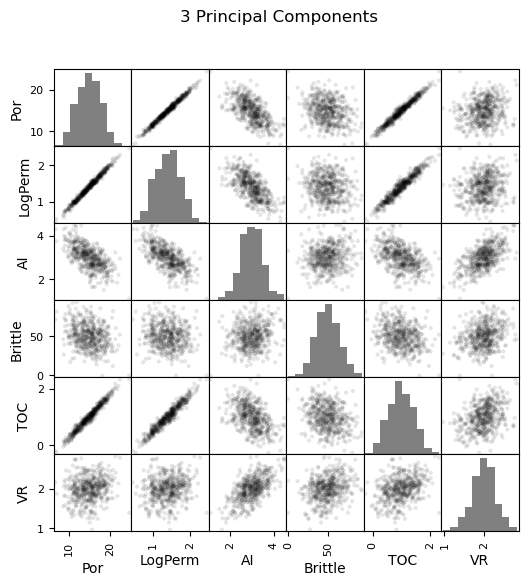

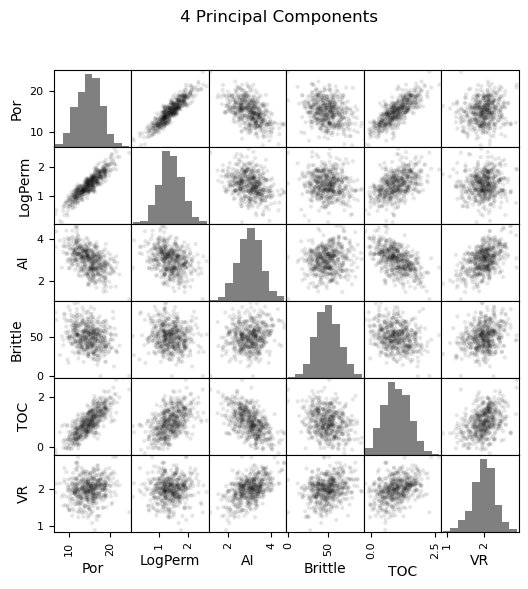

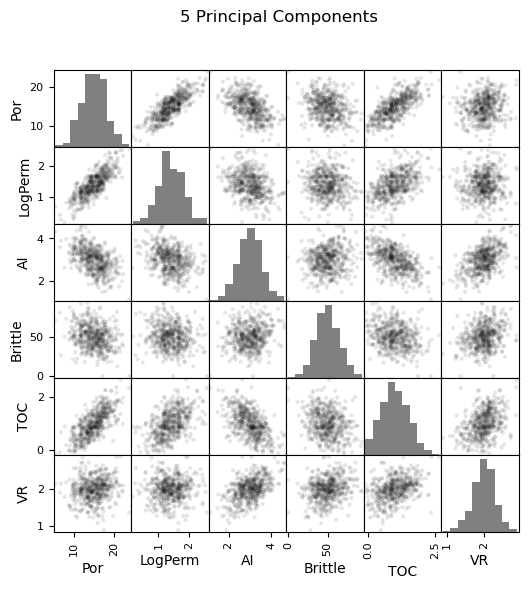

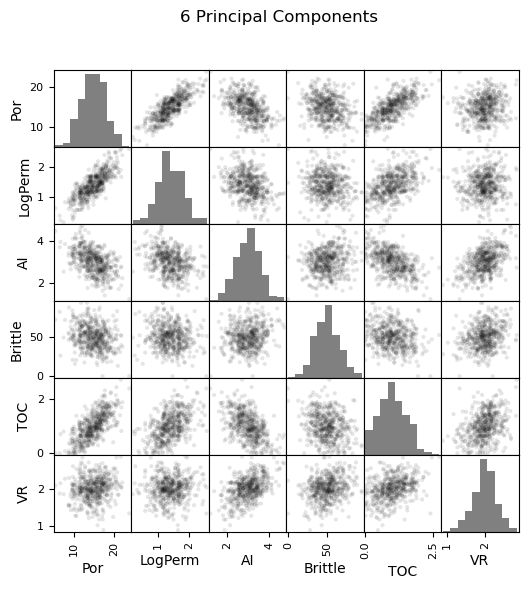

In [36]:
fig = plt.figure()

pd_plot.scatter_matrix(my_data_f6, alpha = 0.1,           # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('Original Data')

pd_plot.scatter_matrix(df_1d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('1 Principal Component')

pd_plot.scatter_matrix(df_2d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('2 Principal Components')

pd_plot.scatter_matrix(df_3d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('3 Principal Components')

pd_plot.scatter_matrix(df_4d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('4 Principal Components')

pd_plot.scatter_matrix(df_5d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('5 Principal Components')

pd_plot.scatter_matrix(df_6d, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('6 Principal Components')

plt.show()

#### Principal Components Analysis on Uncorrelated Data

Let's try one more test, principal components analysis on uncorrelated data.  

* we generate a large number of random samples (n is large) for 5 feature.

* we will assume a uniform distribution

Variance of original features:  [0.08 0.08 0.08 0.08 0.08]
Proportion of variance of original features:  [0.2 0.2 0.2 0.2 0.2]
Correlation Matrix of original features:

[[ 0.08 -0.   -0.    0.    0.  ]
 [-0.    0.08 -0.    0.   -0.  ]
 [-0.   -0.    0.08  0.   -0.  ]
 [ 0.    0.    0.    0.08  0.  ]
 [ 0.   -0.   -0.    0.    0.08]]



PCA Variance Explained  [0.21 0.2  0.2  0.2  0.19]

Correlation Matrix of scores:

[[ 0.09  0.   -0.   -0.   -0.  ]
 [ 0.    0.09 -0.   -0.   -0.  ]
 [-0.   -0.    0.08 -0.   -0.  ]
 [-0.   -0.   -0.    0.08 -0.  ]
 [-0.   -0.   -0.   -0.    0.08]]



Text(0.5, 0.98, 'Principal Component Scores')

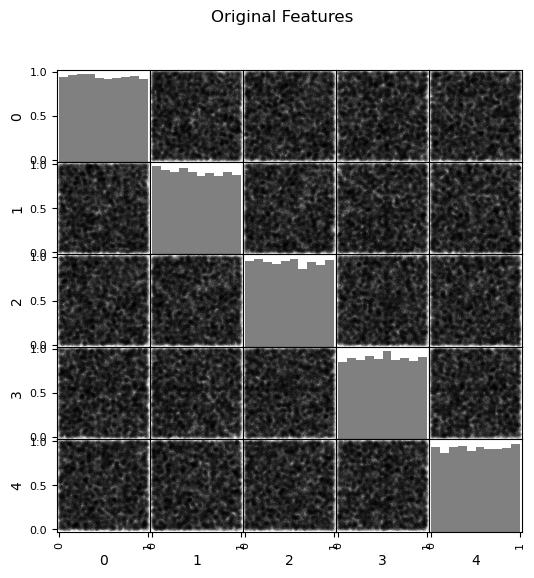

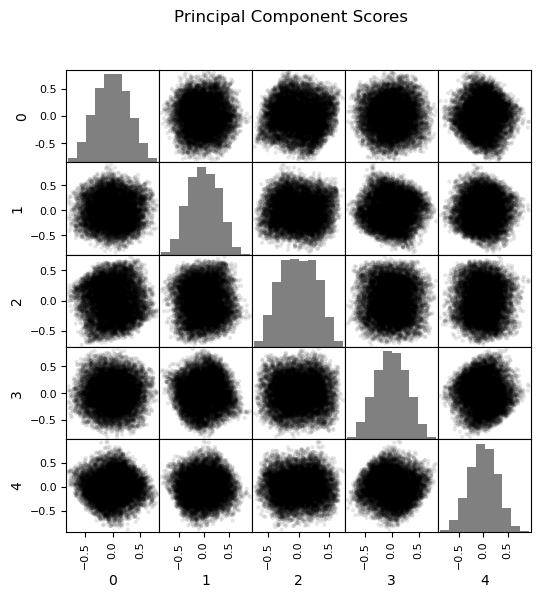

In [37]:
x_rand = np.random.rand(10000,5); df_x_rand = pd.DataFrame(x_rand)
print('Variance of original features: ', np.round(np.var(x_rand, axis = 0),2))
print('Proportion of variance of original features: ', np.round(np.var(x_rand, axis = 0)/np.sum(np.var(x_rand, axis = 0)),2))
print('Correlation Matrix of original features:\n'); print(np.round(np.cov(x_rand, rowvar = False),2)); print()

pd_plot.scatter_matrix(df_x_rand, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('Original Features')

pca_rand = PCA(n_components=5)
pca_rand.fit(x_rand)
print('PCA Variance Explained ', np.round(pca_rand.explained_variance_ratio_,2))  

scores_x_rand = pca_rand.transform(x_rand); df_scores_x_rand = pd.DataFrame(scores_x_rand)

print('\nCorrelation Matrix of scores:\n'); print(np.round(np.cov(scores_x_rand, rowvar = False),2)); print()

pd_plot.scatter_matrix(df_scores_x_rand, alpha = 0.1,                # pandas matrix scatter plot
    figsize=(6, 6),color = 'black', hist_kwds={'color':['grey']})
plt.suptitle('Principal Component Scores')

What happenned with principal component analysis applied to uncorrelated, uniformly distributed features?

* all the principal components described the same amount of variance

* there is no opportunity for dimensionality reduction through feature projection

* the linear combination of independent random variables invokes the central limit theorem, the principle component scores tend to Gaussian distribution.

There are so many more tests that one could attempt to gain experience with principal components analysis. I'll end here for brevity, but I invite you to continue. Consider, on your own apply other data sets or attempting methods with PCA kernels or regression.  I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

#### Comments

This was a basic demonstration of principal component analysis for dimensional reduction. A lot more could be done, for example, there are methods that reduce the dimensionality, and remove dependency to allow for independent variable modeling workflows etc.